# Solving a SOLA problem using the Problem class

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [69]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
import numpy as np
import seaborn as sns

Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [70]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['vs', 'vp', 'rho']
# Edit region -------------

no_of_params = len(physical_parameters)

EarthDomain = HyperParalelipiped(bounds=[[0, 6371]], fineness=1000)
constituent_models_spaces = [PCb(domain=EarthDomain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. This is also where we iport the sensitivity kernels.

In [71]:
###################
# Create Data space
###################
# Edit region -------------
data_directory = '/disks/data/PhD/BGSOLA/SOLA_DLI/kernels_modeplotaat_Adrian'
which_data = list(np.arange(0, 100))
# Edit region -------------

# Import sensitivity data
how_many_data = len(which_data)
raw_sensitivity_dict = {}
raw_sensitivity_domains_dict = {}
for param in physical_parameters:
    raw_sensitivity_domain, raw_sensitivity = load_normal_data(param, data_directory)
    raw_sensitivity_dict[param] = np.array(raw_sensitivity)[which_data]
    if param not in raw_sensitivity_domains_dict:
        raw_sensitivity_domains_dict[param] = raw_sensitivity_domain
D = RN(dimension=how_many_data)

The the model-data mapping.

In [72]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for param in physical_parameters:
    sensitivity_dict[param] = []
    for discrete_sensitivity_kernel in raw_sensitivity_dict[param]:
        sensitivity_dict[param].append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                        raw_domain=raw_sensitivity_domains_dict[param],
                                                        domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [73]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'vs': Gaussian_1D,
                'vp': Null_1D,
                'rho': Null_1D}
width = 1000 # same units as domain (km here)
how_many_targets = 100
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             how_many_targets)
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Gaussian_1D:
            targets_dict[param].append(target_type(domain=EarthDomain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else: 
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

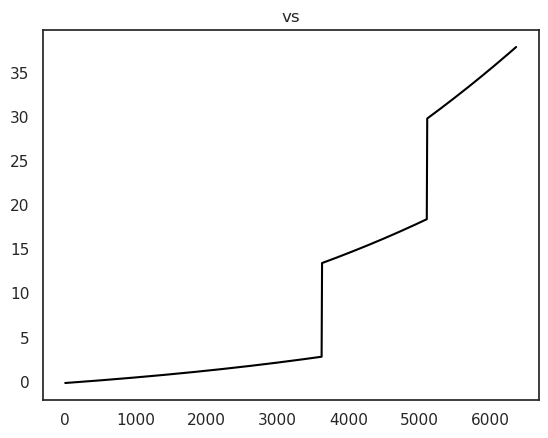

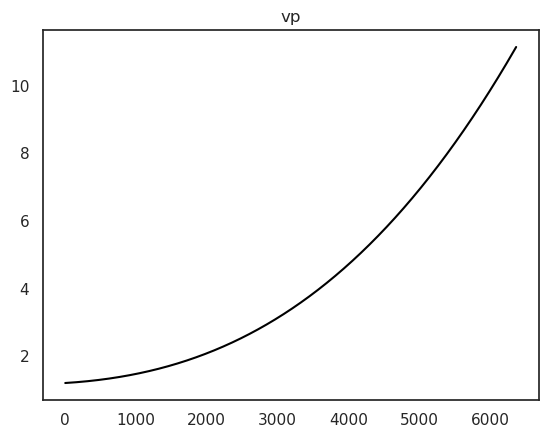

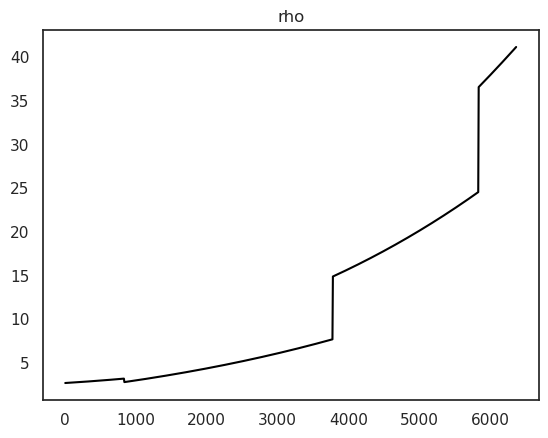

In [74]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(1,), (2,), (3,)])
data = G.map(true_model)

for submodel, physical_parameter in zip(true_model, physical_parameters):
    plt.plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh)[1], label='true', color='black')
    plt.title(physical_parameter)
    plt.show()

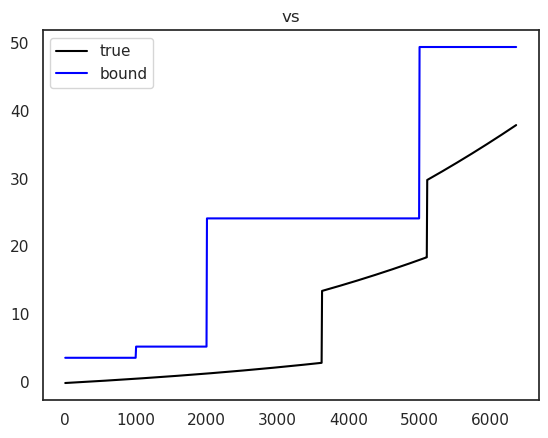

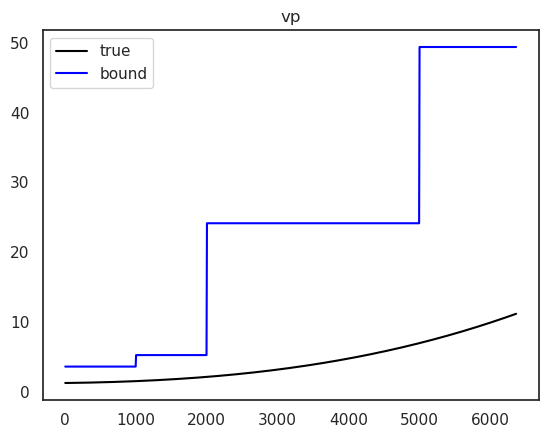

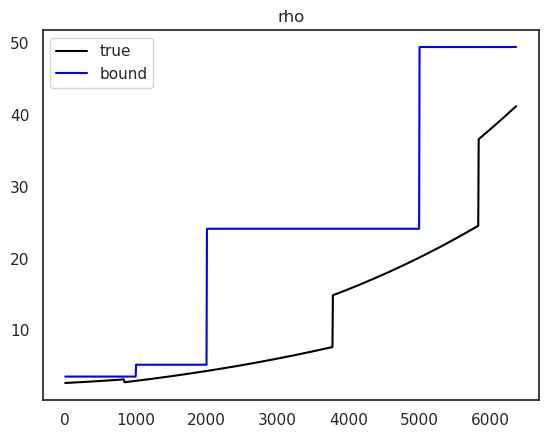

In [75]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,1000, 2000, 5000, EarthDomain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = model.evaluate(intervals[1:])[1]*1.2
    upper_bound = Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

for upperbound, submodel, physical_parameter in zip(upper_bounds, true_model, physical_parameters):
    plt.plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh)[1], label='true', color='black')
    plt.plot(EarthDomain.mesh, upper_bound.evaluate(EarthDomain.mesh)[1], label='bound', color='blue')
    plt.title(physical_parameter)
    plt.legend()
    plt.show()

Now with all the components at hand, we put them all in a "Problem" class instance

In [76]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

The Problem holds all the important parameters of our sola problem introduced by us, like the model space, model-data mappings, etc and many properties that have not been inputed but can be computed (like property bounds, resolving kernels, least norm property solution, etc). The various components that need to be computed to arrive at the solution of our problem are not connected in a linear fashion; that is, going from our initial mathematical object to the final solution is not a simple chain of computations. The problem instance of the Problem class has a dependency graph that shows how the various elements of a SOLA problem are related. 

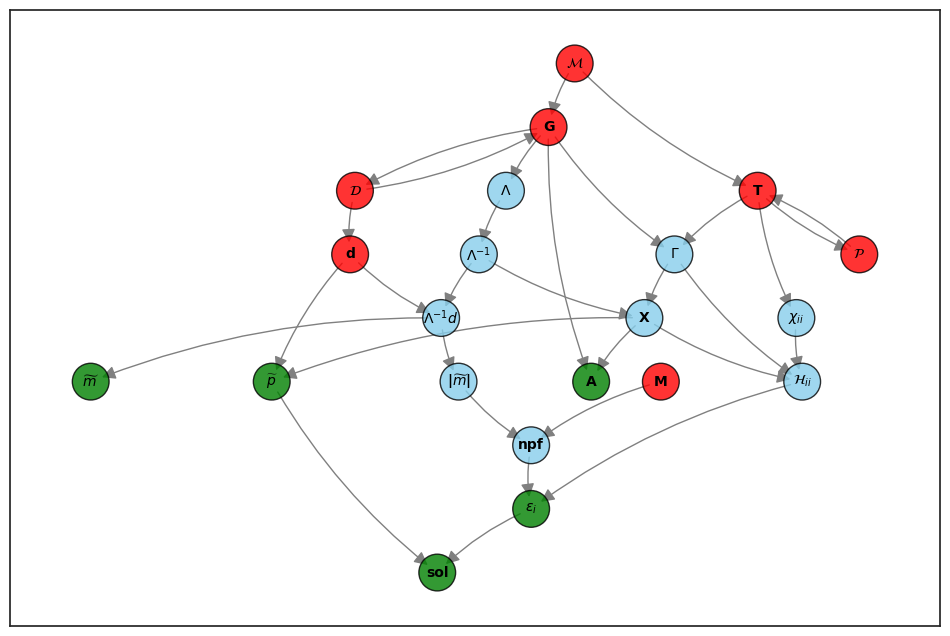

In [77]:
problem.dependencies.plot_dependency_tree()

The red blobs represent elements that we need to build ourselves before even trying to solve the problem (parenthesis - "alias" of the element):
1. $\mathcal{M}$ - Model space (model_space) 
2. $\mathcal{D}$ - Data space (data_space)
3. $\mathcal{P}$ - Property space (property_space)
4. G - Model-Data mapping (G)
5. T - Model-Property mapping (T)
6. d - Data (data)

These elements are normally the ones that we will modify as they define the problem to be solved. 

The green blobs are "end points" for our problem - things we might want to plot for example:

7. sol - Upper and lower bounds on the desired property (solution)
8. $\epsilon_i$ -  Property error bounds (epsilon)
9. A - Resolving kernels (A)
10. $\tilde{p}$ - Least norm property solution (least_norm_property)
11. $\tilde{m}$ - Least norm model solution (least_norm_solution)

The blue blobs are elements that need to be computed in order to arrive at some solution. Some of them are notably expensive/difficult to deal with such as $\Lambda$ and $\Lambda^{-1}$.

12. $\Lambda$ - The kernels Gram matrix (Lambda)
13. $\Lambda^{-1}$ - The kernels Gram matrix inverse (Lambda_inv)
14. $\Lambda^{-1}d$ - The "shuffled"/remapped data (sdata)
15. $\lVert \tilde{m} \rVert$ - Least norm (least_norm)
16. npf - Norm Prefactor, basically $\sqrt{M^2 - \lVert \tilde{m} \rVert^2}$ (npf) 
17. $\Gamma$ - Gamma (Gamma)
18. X - X (X)
19. $\chi_{ii}$ - Diagonal of the matrix containing $\int T_i T_j$ (chi)
20. $\mathcal{H}_{ii}$ - Diagonal of the H matrix (H)


Why did I make this tree? Because sometimes we might want to see how changing some parameters of the problem (red) leads to changes in some important quantities without recomputing everything again from scratch. Using this tree we can see, for example, that if we want to see the effect of changing the norm bound $M$ on the solution we only need to recompute the norm prefactor (npf) and the property error bounds ($\epsilon$). Or, if we only changed the target kernels (T) and want to see the changes in the resolving kernels (A) we only need to recompute Gamma and X. 

This tree is built into the "problem" class and it is being used to asses what needs to be recomputed when a particular element has been changed. 

Given some element of the problem - like resolving kernels A - you can also see what are the elements A depends on using the "find_dependent_nodes" method:

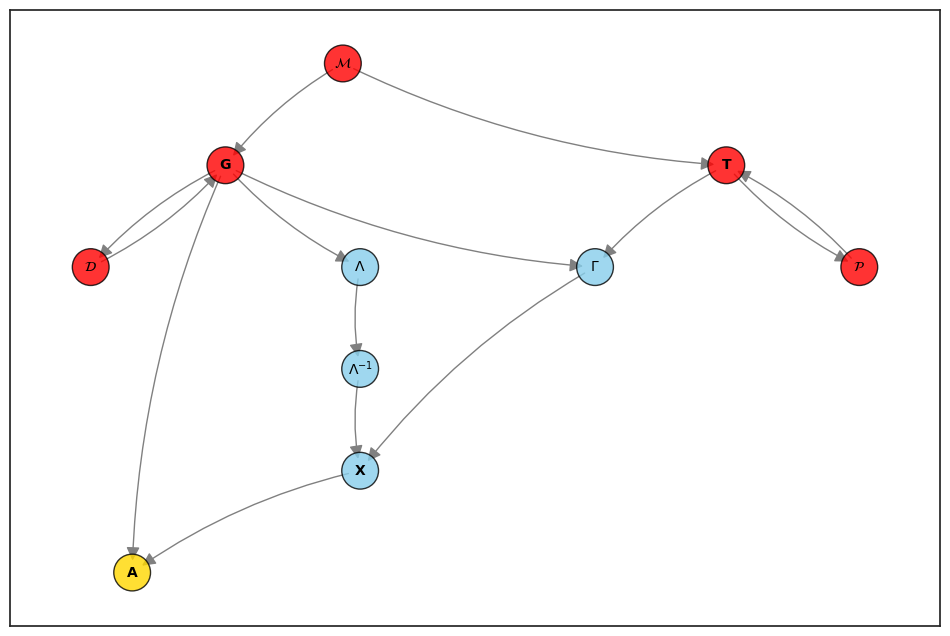

In [78]:
dependent_nodes = problem.dependencies.find_dependent_nodes('A', plot_dependent_tree=True)

We can also see what are all the elements affected (need recomputation) when changing another element

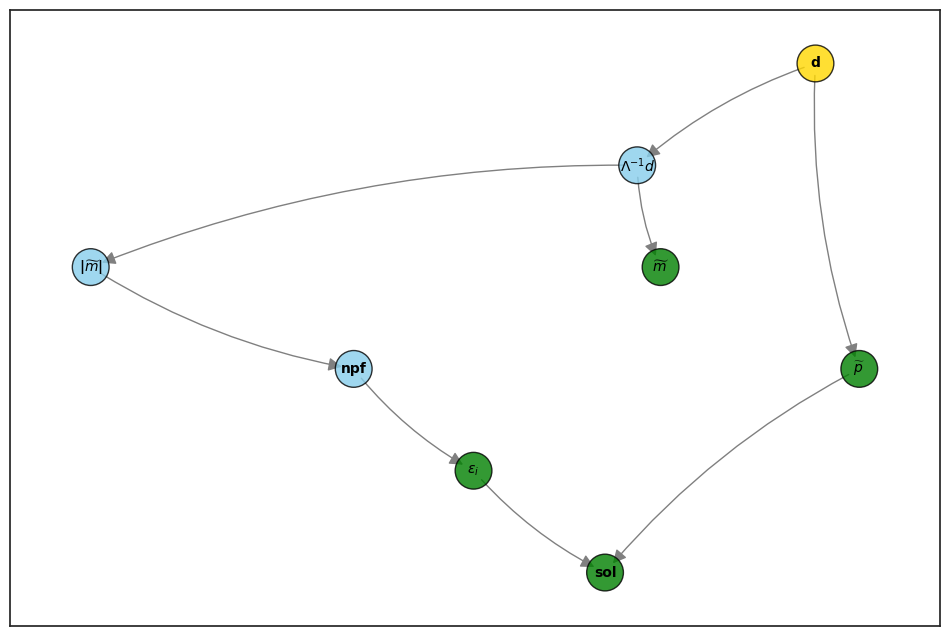

In [79]:
reacheable_nodes = problem.dependencies.find_reachable_nodes('d', plot_reachable_graph=True)

Now let's start solving the problem. This is easy, just do:

In [80]:
problem.solve()

With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

(-50.0, 50.0)

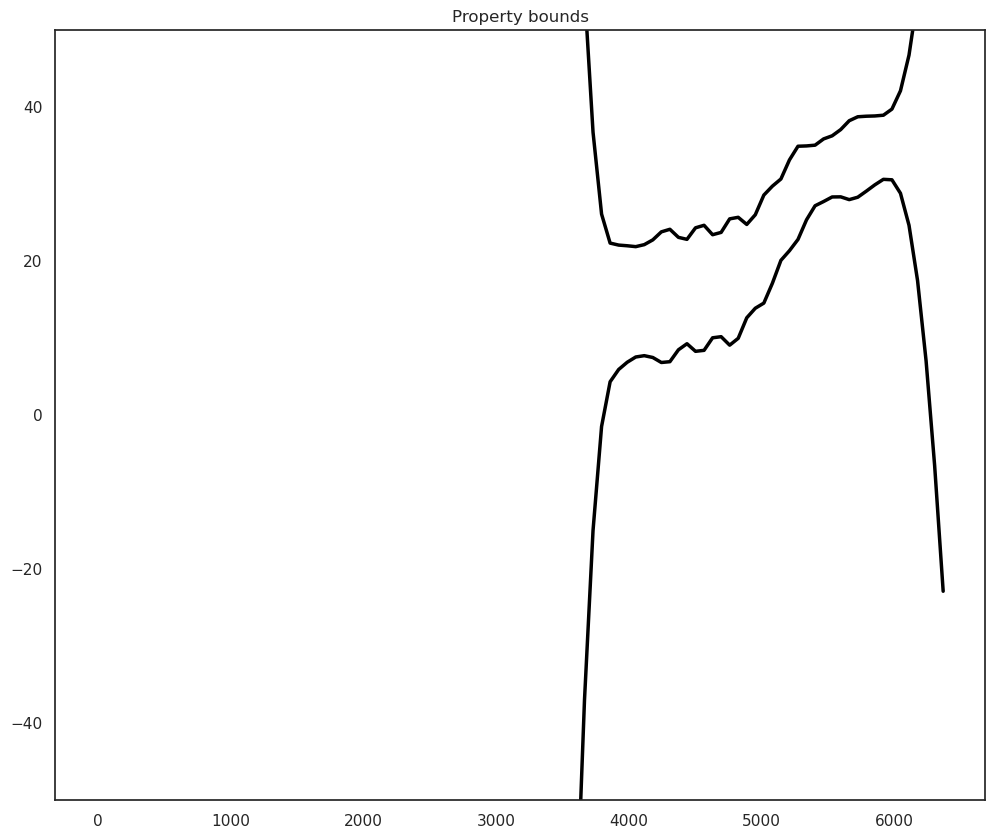

In [81]:
###############
# Plot solution
###############
plt.figure(figsize=(12,10))
sns.set(style='white')
sns.set_palette('YlGnBu')
blues = plt.get_cmap('YlGnBu')
plt.title('Property bounds')
plt.plot(enquiry_points, problem.solution['upper bound'], color='black', linewidth=2.5, label='bounds')
plt.plot(enquiry_points, problem.solution['lower bound'], color='black', linewidth=2.5,)
plt.ylim([-50, 50])

In [82]:
####################
# Create model space
####################
physical_parameters = ['vs', 'vp']
constituent_models_spaces = [PCb(domain=EarthDomain) for _ in physical_parameters]
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))
###########################
# Create model-data mapping
###########################
constituent_mappings = {mappings_dict[key] for key in physical_parameters}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'vs': Gaussian_1D,
                'vp': Null_1D}
width = 1000 # same units as domain (km here)
how_many_targets = 100
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             how_many_targets)
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Gaussian_1D:
            targets_dict[param].append(target_type(domain=EarthDomain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else: 
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))
problem.change_M()

TypeError: Problem.change_M() missing 3 required positional arguments: 'new_M', 'new_G', and 'new_T'